<a href="https://colab.research.google.com/github/robpalinic/Springboard-Projects/blob/main/Take_Home_Relax_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Take Home Challenge:  Relax**
**Defining an "adopted user" as a user who has logged into the product on three separate
days in at least one seven ­day period, identify which factors predict future user
adoption.**

## **1. Import Libraries and Data**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, plot_roc_curve
from collections import defaultdict

In [2]:
engagement = pd.read_csv('/content/drive/MyDrive/relax_challenge/takehome_user_engagement.csv')
users = pd.read_csv('/content/drive/MyDrive/relax_challenge/takehome_users.csv',encoding='latin1')

## **2. Investigate Data**

In [3]:
users.head(1)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0


In [4]:

#users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'],unit='s', origin='unix')
# users['creation_time'] = pd.to_datetime(users['creation_time'] )
# users['time_differences'] = users['last_session_creation_time'] - users['creation_time']
# users['time_differences'] = users['time_differences']/np.timedelta64(1,'D')

In [5]:
users.set_index('object_id', inplace=True)

In [6]:
engagement.head(2)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1


In [7]:
print(engagement['time_stamp'].min(), engagement['time_stamp'].max())

2012-05-31 08:20:06 2014-06-06 14:58:50


In [8]:
#Count the number of unique users

engagement['user_id'].nunique()

8823

In [9]:
#Get the number of days in the range

date_format = "%Y-%m-%d %H:%M:%S"
a = datetime.strptime(str(engagement['time_stamp'].min()), date_format)
b = datetime.strptime(str(engagement['time_stamp'].max()), date_format)
delta = b - a
delta = int(delta.days)

In [10]:
#Identify any user who has used the product at least 3 times in a 7 day window.

engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])

start = pd.to_datetime(engagement['time_stamp'].min()) - timedelta(days=1)
end = pd.to_datetime(engagement['time_stamp'].min()) + timedelta(days=6) 

ids = []

for i in range(0, delta):
  start = pd.to_datetime(start + timedelta(days=1))
  end = pd.to_datetime(end + timedelta(days=1))
  a = engagement[(engagement['time_stamp']>=start) & (engagement['time_stamp']<=end)]
  b = pd.DataFrame(a.groupby('user_id')['time_stamp'].count())
  c = pd.DataFrame(b[b.time_stamp>2])
  if c.empty:
    pass
  else:
    #ids.append((c.index)[0])
    d = list(c.index.values)
    for i in d:
      ids.append(i)

adopted_users = list(set(ids))

In [11]:
print(len(adopted_users))

1602


**1602 of the users can be termed adopted users, having used the product three times within a seven day time window.**

In [12]:
for user in adopted_users:
  users.loc[user, 'adopted_user'] = 1
users.fillna(0, inplace=True)

In [13]:
users.head(1)

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
object_id,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0


In [14]:
#Drop fields that are descriptive of users but not of their source or characteristics

users.drop(['name', 'email', 'creation_time',  'last_session_creation_time'], inplace=True, axis=1)
#'invited_by_user_id',

## **Process Data for Modeling**

In [15]:
X = users.drop('adopted_user', axis=1)
y = users['adopted_user']

In [16]:
X = pd.get_dummies(X)
columns = X.columns

In [17]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = columns)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

## **Modeling**

In [19]:
#Create and fit a logistic regression model

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [20]:
#Model ROC score

roc_auc_score(y_test, y_pred)

0.5

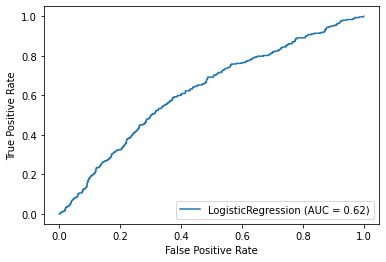

In [21]:
#Graphically show the model's predictive ability

plot_roc_curve(lr, X_test, y_test);

In [22]:
feature_importance = defaultdict(float)
columns = np.array(columns)
for i in range(0, 7):
  feature_importance[columns[i]] = round(lr.coef_[0][i], 2)

feature_importance

defaultdict(float,
            {'creation_source_GUEST_INVITE': 0.1,
             'creation_source_ORG_INVITE': -0.01,
             'creation_source_PERSONAL_PROJECTS': -0.2,
             'enabled_for_marketing_drip': -0.01,
             'invited_by_user_id': 0.04,
             'opted_in_to_mailing_list': 0.03,
             'org_id': 0.17})

## **Conclusions**

Out of 8823 total users, 1602 can be termed adopted user, being active three or more times in a seven day period.  The data on hand is insufficient to reliabily predict who will be an adopted user, as the AUC is only .62.  The only predictive feature appears to be org_id.